# Audio Emotion Analysis

## Import Libraries

In [23]:
# Core libraries
import glob # For collecting files together
import os # 
import sys
import pickle
import re

# Data Analysis and Wrangling
import pandas as pd
import numpy as np
import random as rnd

# Visualization
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.ensemble import GradientBoostingClassifier

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio


# Task Specific
import librosa
import librosa.display


### Test Cuda GPU Processing is Active

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing Data

In [3]:
import IPython.display as ipd # For playing sounds.
ipd.Audio('./Audio Emotion/Actor_01/03-01-01-01-01-01-01.wav')

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

Filename identifiers 

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Shape of waveform: torch.Size([1, 158558])
Sample rate of waveform: 48000


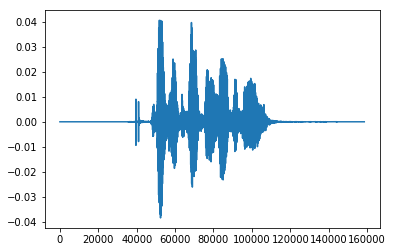

In [4]:
filename = "./Audio Emotion/Actor_01/03-01-01-01-01-01-01.wav"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

Shape of spectrogram: torch.Size([1, 201, 793])


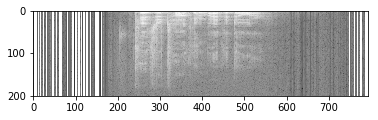

In [13]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

Shape of spectrogram: torch.Size([1, 128, 793])


C:\ProgramData\Anaconda3\lib\site-packages\torchaudio\functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


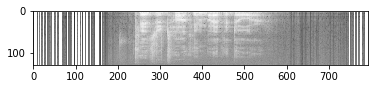

In [10]:
specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='gray')

Paths

Modality (01 = full-AV, 02 = video-only, 03 = audio-only). Vocal channel (01 = speech, 02 = song). Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised). Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion. Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”). Repetition (01 = 1st repetition, 02 = 2nd repetition). Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

## Razi Extraction Code

In [5]:
def load_and_get_audio_data(path_to_data_for_audio):
    """
    
    path_to_data_for_audio: Path to the Audio_Speech_Actors_01 folder.
    output: Pandas Dataframe
    
    source: https://github.com/mkosaka1/Speech_Emotion_Recognition
    """

    actor_folders = os.listdir(path_to_data_for_audio)


    emotion = []
    gender = []
    actor = []
    file_path = []
    for i in actor_folders:
        filename = os.listdir(path_to_data_for_audio + i) #iterate over Actor folders
        for f in filename: # go through files in Actor folder
            part = f.split('.')[0].split('-')
            emotion.append(int(part[2]))
            actor.append(int(part[6]))
            bg = int(part[6])
            if bg%2 == 0:
                bg = "female"
            else:
                bg = "male"
            gender.append(bg)
            file_path.append(path_to_data_for_audio + i + '/' + f)
    # PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
    audio_df = pd.DataFrame(emotion)
    audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
    audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
    audio_df.columns = ['gender','emotion','actor']
    audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
    
    
    
    # ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
    df = pd.DataFrame(columns=['mel_spectrogram'])

    counter=0

    for index,path in enumerate(audio_df.path):
        X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)

        #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
        spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
        db_spec = librosa.power_to_db(spectrogram)
        #temporally average spectrogram
        log_spectrogram = np.mean(db_spec, axis = 0)

        df.loc[counter] = [log_spectrogram]
        counter=counter+1   
    
    
    df_combined = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
    df_combined = df_combined.fillna(0)
    df_combined.drop(columns='path',inplace=True)
    
    
    return df_combined

In [6]:
#path_to_data_for_audio = "Data/AudioEmotion/AudioEmotion/Audio_Speech_Actors_01-24/"
path_to_data_for_audio = './Audio Emotion/'
audio_data = load_and_get_audio_data(path_to_data_for_audio)
audio_data.head()

,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,male,neutral,1,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,male,neutral,1,-75.335518,-75.445320,-75.554031,-75.203949,-75.230530,-75.319374,-75.653793,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,male,neutral,1,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male,neutral,1,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male,calm,1,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,...,-80.147377,-80.147377,-80.121956,-79.998009,-80.119255,-80.147377,-80.130417,-80.014702,-80.147377,-80.147377


## Transforming Data

In [14]:
train,test = train_test_split(audio_data, test_size=0.2, random_state=0,
                               stratify=audio_data[['emotion','gender','actor']])

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])

In [15]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

## Exploratory Data Analysis

In [7]:
audio_data.describe

<bound method NDFrame.describe of       gender   emotion  actor          0          1          2          3  \
0       male   neutral      1 -76.384773 -76.384773 -76.384773 -76.384773   
1       male   neutral      1 -75.335518 -75.445320 -75.554031 -75.203949   
2       male   neutral      1 -75.150711 -75.150711 -75.150711 -75.150711   
3       male   neutral      1 -75.268448 -75.268448 -75.268448 -75.268448   
4       male      calm      1 -80.147377 -80.147377 -80.147377 -80.147377   
...      ...       ...    ...        ...        ...        ...        ...   
1435  female  surprise     24 -66.861420 -66.861420 -64.904045 -64.663895   
1436  female  surprise     24 -62.385349 -62.385349 -62.385349 -62.385349   
1437  female  surprise     24 -65.515594 -65.515594 -65.515594 -65.515594   
1438  female  surprise     24 -63.501076 -63.501076 -63.420914 -62.750462   
1439  female  surprise     24 -45.199841 -43.823120 -44.344078 -45.735817   

              4          5          6  ..

In [8]:
audio_data.size

377280

In [54]:
audio_data.info

<bound method DataFrame.info of       gender   emotion  actor          0          1          2          3  \
0       male   neutral      1 -76.384773 -76.384773 -76.384773 -76.384773   
1       male   neutral      1 -75.335518 -75.445320 -75.554031 -75.203949   
2       male   neutral      1 -75.150711 -75.150711 -75.150711 -75.150711   
3       male   neutral      1 -75.268448 -75.268448 -75.268448 -75.268448   
4       male      calm      1 -80.147377 -80.147377 -80.147377 -80.147377   
...      ...       ...    ...        ...        ...        ...        ...   
1435  female  surprise     24 -66.861420 -66.861420 -64.904045 -64.663895   
1436  female  surprise     24 -62.385349 -62.385349 -62.385349 -62.385349   
1437  female  surprise     24 -65.515594 -65.515594 -65.515594 -65.515594   
1438  female  surprise     24 -63.501076 -63.501076 -63.420914 -62.750462   
1439  female  surprise     24 -45.199841 -43.823120 -44.344078 -45.735817   

              4          5          6  ... 

In [55]:
audio_data.shape

(1440, 262)

In [56]:
audio_data.dtypes

gender      object
emotion     object
actor        int64
0          float64
1          float64
            ...   
254        float64
255        float64
256        float64
257        float64
258        float64
Length: 262, dtype: object

In [ ]:
uniqueDf = audio_data.groupby('emotion')['ID'].nunique()

print (uniqueDf)

Shape of waveform: torch.Size([1, 158558])
Sample rate of waveform: 48000


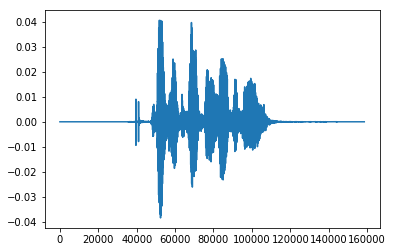

In [9]:
# In torchaudio
filename = "./Audio Emotion/Actor_01/03-01-01-01-01-01-01.wav"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

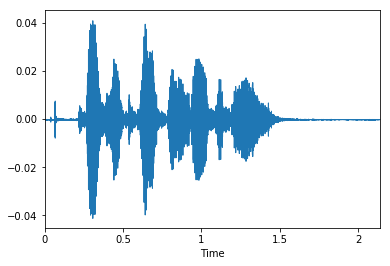

In [11]:
# In librosa
filename = "./Audio Emotion/Actor_01/03-01-01-01-01-01-01.wav"
waveform, sample_rate = librosa.load(filename)

whale_song, _ = librosa.effects.trim(waveform)
librosa.display.waveplot(whale_song, sr=sample_rate);
#print("Shape of waveform: {}".format(waveform.size()))
#print("Sample rate of waveform: {}".format(sample_rate))

#plt.figure()
#plt.plot(waveform.t().numpy())

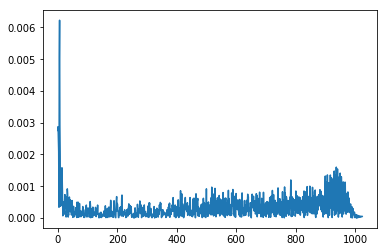

In [12]:
import numpy as np
import matplotlib.pyplot as plt

n_fft = 2048
D = np.abs(librosa.stft(whale_song[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(D);

## Model Fitting

### Benchmark

In [25]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)
y_pred = dummy_clf.predict(X_test)
print("Train Accuracy: ", dummy_clf.score(X_train, y_train))
print("Test Accuracy: ", dummy_clf.score(X_test,y_test))
print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))

Train Accuracy:  0.1328125
Test Accuracy:  0.08680555555555555
F1 Score:  0.13035997622231799
Recall:  0.13334064436038118
Precision:  0.1292572949320033


In [17]:
#clf = tree.DecisionTreeClassifier() # We're using a decision tree as the benchmark model.
#clf = DecisionTreeClassifier(random_state=0)
clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, y_train)
clf.predict(X_test)
#clf.score(X_test, y_test)
print("Train Accuracy: ", clf.score(X_train, y_train))
print("Test Accuracy: ", clf.score(X_test,y_test))

Train Accuracy:  1.0
Test Accuracy:  0.34375


## Models

### Dummy Model

In [18]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)
y_pred = dummy_clf.predict(X_test)
print("Train Accuracy: ", dummy_clf.score(X_train, y_train))
print("Test Accuracy: ", dummy_clf.score(X_test,y_test))
print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))



Train Accuracy:  0.1293402777777778
Test Accuracy:  0.14930555555555555
F1 Score:  0.09018683403199286
Recall:  0.09124156870867396
Precision:  0.09111038408639027


### Logistic Recreation

In [19]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train.values.ravel())
y_pred = log_reg.predict(X_test)
print("Train Accuracy: ", log_reg.score(X_train, y_train))
print("Test Accuracy: ", log_reg.score(X_test,y_test))
print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))

Train Accuracy:  0.6571180555555556
Test Accuracy:  0.3125
F1 Score:  0.30158976776408386
Recall:  0.30193483318483316
Precision:  0.30394835211577


### Decision Tree

In [107]:
DC = DecisionTreeClassifier(random_state=42)
DC.fit(X_train, y_train)
y_pred = DC.predict(X_test)
print("Train Accuracy: ", DC.score(X_train, y_train))
print("Test Accuracy: ", DC.score(X_test,y_test))
print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))

Train Accuracy:  1.0
Test Accuracy:  0.34375
F1 Score:  0.3388869175036177
Recall:  0.3376568695647643
Precision:  0.34254370629370634


In [108]:
# iterate over a few depth values
for depth in range(1, 25):
 # init the model
    clf = DecisionTreeClassifier(random_state=42,max_depth=depth)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Depth: ", depth)
    print("Train Accuracy: ", clf.score(X_train, y_train))
    print("Test Accuracy: ", clf.score(X_test,y_test))
    print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
    print("Recall: ", recall_score(y_test, y_pred, average='macro'))
    print("Precision: ", precision_score(y_test, y_pred, average='macro'))

Depth:  1
Train Accuracy:  0.2465277777777778
Test Accuracy:  0.23958333333333334
F1 Score:  0.09580792682926828
Recall:  0.22402159244264508
Precision:  0.06119148726051748
Depth:  2
Train Accuracy:  0.2821180555555556
Test Accuracy:  0.2465277777777778
F1 Score:  0.1787937130679066
Recall:  0.23933632157316367
Precision:  0.18415785186033784


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Depth:  3
Train Accuracy:  0.3576388888888889
Test Accuracy:  0.3055555555555556
F1 Score:  0.230065940837271
Recall:  0.2871712805923332
Precision:  0.22034006694032066
Depth:  4
Train Accuracy:  0.421875
Test Accuracy:  0.3229166666666667
F1 Score:  0.268620173025154
Recall:  0.31103649195754457
Precision:  0.25748366543166423


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Depth:  5
Train Accuracy:  0.4869791666666667
Test Accuracy:  0.3368055555555556
F1 Score:  0.2985597635708951
Recall:  0.3397983003246161
Precision:  0.2871099737548979
Depth:  6


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy:  0.5694444444444444
Test Accuracy:  0.3263888888888889
F1 Score:  0.31710610123617666
Recall:  0.3235768572939625
Precision:  0.34227393912877785
Depth:  7
Train Accuracy:  0.6493055555555556
Test Accuracy:  0.3333333333333333
F1 Score:  0.32653308557462757
Recall:  0.33133750436382015
Precision:  0.32950507320451705
Depth:  8
Train Accuracy:  0.7352430555555556
Test Accuracy:  0.3784722222222222
F1 Score:  0.36482891932537465
Recall:  0.3682490562424773
Precision:  0.3662453647020948
Depth:  9
Train Accuracy:  0.8020833333333334
Test Accuracy:  0.3680555555555556
F1 Score:  0.36321851938353766
Recall:  0.36459854157222576
Precision:  0.3709353303838774
Depth:  10
Train Accuracy:  0.8611111111111112
Test Accuracy:  0.3229166666666667
F1 Score:  0.3193236915053312
Recall:  0.3199186733726207
Precision:  0.320097414686521
Depth:  11
Train Accuracy:  0.9088541666666666
Test Accuracy:  0.3368055555555556
F1 Score:  0.3296579202574384
Recall:  0.33053991853333964
Precision: 

### Random Forest

In [20]:
rf_reg = RandomForestClassifier(random_state=42)
rf_reg.fit(X_train, y_train.values.ravel())
y_pred = rf_reg.predict(X_test)
print("Train Accuracy: ", rf_reg.score(X_train, y_train))
print("Test Accuracy: ", rf_reg.score(X_test,y_test))
print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))

Train Accuracy:  1.0
Test Accuracy:  0.4652777777777778
F1 Score:  0.4626830083730994
Recall:  0.46356684004710325
Precision:  0.46670488438062124


In [130]:
# iterate over a few depth values AND number trees AND number of variables chosen
bestDepth = 0
bestNumberTrees = 0
bestNumberVariables = 0
bestAccuracy = 0.00

for depth in range(1, 25):
    for numberTrees in range (50,500,50):
        for numberVariables in range (10,50,10):
            # init the model
            rf_reg = RandomForestClassifier(random_state=42,max_depth=depth,n_estimators=numberTrees, max_features = numberVariables)
            rf_reg.fit(X_train, y_train.values.ravel())
            y_pred = rf_reg.predict(X_test)
            #rf_reg.fit(X_train, y_train)
            print("Depth: ", depth)
            print("Number of Trees: ", numberTrees)
            print("Number of Variables: ", numberVariables)
            #print("Train Accuracy: ", rf_reg.score(X_train, y_train))
            #print("Test Accuracy: ", rf_reg.score(X_test,y_test))
            #print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
            #print("Recall: ", recall_score(y_test, y_pred, average='macro'))
            #print("Precision: ", precision_score(y_test, y_pred, average='macro'))
            if rf_reg.score(X_test,y_test) > bestAccuracy:
                bestAccuracy = rf_reg.score(X_test,y_test)
                bestDepth = depth
                bestNumberTrees = numberTrees
                bestNumberVariables = numberVariables

print(bestDepth)
print(bestNumberTrees)
print(bestNumberVariables)
print(bestAccuracy)

Depth:  1
Number of Trees:  50
Number of Variables:  10
Depth:  1
Number of Trees:  50
Number of Variables:  20
Depth:  1
Number of Trees:  50
Number of Variables:  30
Depth:  1
Number of Trees:  50
Number of Variables:  40
Depth:  1
Number of Trees:  100
Number of Variables:  10
Depth:  1
Number of Trees:  100
Number of Variables:  20
Depth:  1
Number of Trees:  100
Number of Variables:  30
Depth:  1
Number of Trees:  100
Number of Variables:  40
Depth:  1
Number of Trees:  150
Number of Variables:  10
Depth:  1
Number of Trees:  150
Number of Variables:  20
Depth:  1
Number of Trees:  150
Number of Variables:  30
Depth:  1
Number of Trees:  150
Number of Variables:  40
Depth:  1
Number of Trees:  200
Number of Variables:  10
Depth:  1
Number of Trees:  200
Number of Variables:  20
Depth:  1
Number of Trees:  200
Number of Variables:  30
Depth:  1
Number of Trees:  200
Number of Variables:  40
Depth:  1
Number of Trees:  250
Number of Variables:  10
Depth:  1
Number of Trees:  250
Num

Depth:  5
Number of Trees:  50
Number of Variables:  20
Depth:  5
Number of Trees:  50
Number of Variables:  30
Depth:  5
Number of Trees:  50
Number of Variables:  40
Depth:  5
Number of Trees:  100
Number of Variables:  10
Depth:  5
Number of Trees:  100
Number of Variables:  20
Depth:  5
Number of Trees:  100
Number of Variables:  30
Depth:  5
Number of Trees:  100
Number of Variables:  40
Depth:  5
Number of Trees:  150
Number of Variables:  10
Depth:  5
Number of Trees:  150
Number of Variables:  20
Depth:  5
Number of Trees:  150
Number of Variables:  30
Depth:  5
Number of Trees:  150
Number of Variables:  40
Depth:  5
Number of Trees:  200
Number of Variables:  10
Depth:  5
Number of Trees:  200
Number of Variables:  20
Depth:  5
Number of Trees:  200
Number of Variables:  30
Depth:  5
Number of Trees:  200
Number of Variables:  40
Depth:  5
Number of Trees:  250
Number of Variables:  10
Depth:  5
Number of Trees:  250
Number of Variables:  20
Depth:  5
Number of Trees:  250
Nu

Depth:  9
Number of Trees:  50
Number of Variables:  30
Depth:  9
Number of Trees:  50
Number of Variables:  40
Depth:  9
Number of Trees:  100
Number of Variables:  10
Depth:  9
Number of Trees:  100
Number of Variables:  20
Depth:  9
Number of Trees:  100
Number of Variables:  30
Depth:  9
Number of Trees:  100
Number of Variables:  40
Depth:  9
Number of Trees:  150
Number of Variables:  10
Depth:  9
Number of Trees:  150
Number of Variables:  20
Depth:  9
Number of Trees:  150
Number of Variables:  30
Depth:  9
Number of Trees:  150
Number of Variables:  40
Depth:  9
Number of Trees:  200
Number of Variables:  10
Depth:  9
Number of Trees:  200
Number of Variables:  20
Depth:  9
Number of Trees:  200
Number of Variables:  30
Depth:  9
Number of Trees:  200
Number of Variables:  40
Depth:  9
Number of Trees:  250
Number of Variables:  10
Depth:  9
Number of Trees:  250
Number of Variables:  20
Depth:  9
Number of Trees:  250
Number of Variables:  30
Depth:  9
Number of Trees:  250
N

Depth:  13
Number of Trees:  50
Number of Variables:  20
Depth:  13
Number of Trees:  50
Number of Variables:  30
Depth:  13
Number of Trees:  50
Number of Variables:  40
Depth:  13
Number of Trees:  100
Number of Variables:  10
Depth:  13
Number of Trees:  100
Number of Variables:  20
Depth:  13
Number of Trees:  100
Number of Variables:  30
Depth:  13
Number of Trees:  100
Number of Variables:  40
Depth:  13
Number of Trees:  150
Number of Variables:  10
Depth:  13
Number of Trees:  150
Number of Variables:  20
Depth:  13
Number of Trees:  150
Number of Variables:  30
Depth:  13
Number of Trees:  150
Number of Variables:  40
Depth:  13
Number of Trees:  200
Number of Variables:  10
Depth:  13
Number of Trees:  200
Number of Variables:  20
Depth:  13
Number of Trees:  200
Number of Variables:  30
Depth:  13
Number of Trees:  200
Number of Variables:  40
Depth:  13
Number of Trees:  250
Number of Variables:  10
Depth:  13
Number of Trees:  250
Number of Variables:  20
Depth:  13
Number

Depth:  16
Number of Trees:  450
Number of Variables:  40
Depth:  17
Number of Trees:  50
Number of Variables:  10
Depth:  17
Number of Trees:  50
Number of Variables:  20
Depth:  17
Number of Trees:  50
Number of Variables:  30
Depth:  17
Number of Trees:  50
Number of Variables:  40
Depth:  17
Number of Trees:  100
Number of Variables:  10
Depth:  17
Number of Trees:  100
Number of Variables:  20
Depth:  17
Number of Trees:  100
Number of Variables:  30
Depth:  17
Number of Trees:  100
Number of Variables:  40
Depth:  17
Number of Trees:  150
Number of Variables:  10
Depth:  17
Number of Trees:  150
Number of Variables:  20
Depth:  17
Number of Trees:  150
Number of Variables:  30
Depth:  17
Number of Trees:  150
Number of Variables:  40
Depth:  17
Number of Trees:  200
Number of Variables:  10
Depth:  17
Number of Trees:  200
Number of Variables:  20
Depth:  17
Number of Trees:  200
Number of Variables:  30
Depth:  17
Number of Trees:  200
Number of Variables:  40
Depth:  17
Number 

Depth:  20
Number of Trees:  450
Number of Variables:  20
Depth:  20
Number of Trees:  450
Number of Variables:  30
Depth:  20
Number of Trees:  450
Number of Variables:  40
Depth:  21
Number of Trees:  50
Number of Variables:  10
Depth:  21
Number of Trees:  50
Number of Variables:  20
Depth:  21
Number of Trees:  50
Number of Variables:  30
Depth:  21
Number of Trees:  50
Number of Variables:  40
Depth:  21
Number of Trees:  100
Number of Variables:  10
Depth:  21
Number of Trees:  100
Number of Variables:  20
Depth:  21
Number of Trees:  100
Number of Variables:  30
Depth:  21
Number of Trees:  100
Number of Variables:  40
Depth:  21
Number of Trees:  150
Number of Variables:  10
Depth:  21
Number of Trees:  150
Number of Variables:  20
Depth:  21
Number of Trees:  150
Number of Variables:  30
Depth:  21
Number of Trees:  150
Number of Variables:  40
Depth:  21
Number of Trees:  200
Number of Variables:  10
Depth:  21
Number of Trees:  200
Number of Variables:  20
Depth:  21
Number 

Depth:  24
Number of Trees:  400
Number of Variables:  40
Depth:  24
Number of Trees:  450
Number of Variables:  10
Depth:  24
Number of Trees:  450
Number of Variables:  20
Depth:  24
Number of Trees:  450
Number of Variables:  30
Depth:  24
Number of Trees:  450
Number of Variables:  40
16
250
20
0.5173611111111112


In [21]:
# Best Random Forest Model
depth = 16
numberTrees = 250
numberVariables = 20
rf_reg = RandomForestClassifier(random_state=42,max_depth=depth,n_estimators=numberTrees, max_features = numberVariables)
rf_reg.fit(X_train, y_train.values.ravel())
y_pred = rf_reg.predict(X_test)
print("Depth: ", depth)
print("Number of Trees: ", numberTrees)
print("Train Accuracy: ", rf_reg.score(X_train, y_train))
print("Test Accuracy: ", rf_reg.score(X_test,y_test))
print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))

Depth:  16
Number of Trees:  250
Train Accuracy:  1.0
Test Accuracy:  0.5173611111111112
F1 Score:  0.5120132682982861
Recall:  0.5168827246129878
Precision:  0.5144724892517748


### Naive Bayes|

In [27]:
from sklearn.naive_bayes import MultinomialNB
NB = GaussianNB()
#NB.fit(X_train, y_train)
NB.fit(X_train, y_train.values.ravel())
y_pred = NB.predict(X_test)
print("Train Accuracy: ", NB.score(X_train, y_train))
print("Test Accuracy: ", NB.score(X_test,y_test))
print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))

Train Accuracy:  0.3741319444444444
Test Accuracy:  0.3888888888888889
F1 Score:  0.36924084016318115
Recall:  0.4015791981252508
Precision:  0.4112049122692495


### SGD

In [28]:
sgd = SGDClassifier()
#sgd.fit(X_train, y_train)
sgd.fit(X_train, y_train.values.ravel())
y_pred = sgd.predict(X_test)
print("Train Accuracy: ", sgd.score(X_train, y_train))
print("Test Accuracy: ", sgd.score(X_test,y_test))
print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))

Train Accuracy:  0.4487847222222222
Test Accuracy:  0.24305555555555555
F1 Score:  0.22454277509213902
Recall:  0.23711266211266208
Precision:  0.23181073312652256


## Gradient Boosting Classifier

In [29]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train.values.ravel())
y_pred = gbc.predict(X_test)


print("Train Accuracy: ", gbc.score(X_train, y_train))
print("Test Accuracy: ", gbc.score(X_test,y_test))
print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))

Train Accuracy:  1.0
Test Accuracy:  0.4270833333333333
F1 Score:  0.41257094811459216
Recall:  0.41629730511309454
Precision:  0.42048450235950235
